# Sketch Classifier for "How Do Humans Sketch Objects?"

A sketch classifier using the dataset from the paper <a href='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/'>How Do Humans Sketch Objects?</a> where the authors collected 20,000 unique sketches evenly distributed over 250 object categories - we will use a CNN (using Keras) to classify a sketch. 

<img src='http://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/teaser_siggraph.jpg'/>

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
import os

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

In [3]:
import keras 
keras.__version__

Using TensorFlow backend.


'2.0.6'

In [53]:
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import Input

from keras.utils import plot_model

from keras import preprocessing
from keras.preprocessing import image

## Trained on Floydhub

In [5]:
DEST_SKETCH_DIR = '/sketches_training_data/'
TARGET_SIZE = (256,256)
CATEGORIES_COUNT = 205
TRAINING_SAMPLES = 12736
VALIDATION_SAMPLES = 3184

In [6]:
!ls /sketches_training_data

training  validation


## Create model 

In [7]:
def plot_accuracy_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [8]:
def train(model, 
          training_dir,
          validation_dir,
          target_size=TARGET_SIZE, 
          training_samples=TRAINING_SAMPLES, 
          validation_samples=VALIDATION_SAMPLES,
          epochs=1000, 
          batch_size=512, 
          load_previous_weights=True,
          model_weights_file=None):
    """
    
    """
    
    if model_weights_file is None:
        raise("No model weights file set")
    
    print("Training STARTED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    if model_weights_file is not None and os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop', 
        metrics=['accuracy'])
    
    # create data generator 
    # check the official documentation for more details: https://keras.io/preprocessing/image/
    datagen = preprocessing.image.ImageDataGenerator(
        rescale=1./255., # rescaling factor applied by multiply the data by this value  
        width_shift_range=0.1, # ranges (as a fraction of total width) to randomly translate pictures 
        height_shift_range=0.1, # ranges (as a fraction of total height) to randomly translate pictures 
        zoom_range=0.1, # randomly zooming inside pictures
        horizontal_flip=True, # randomly flipping half of the images horizontally
        fill_mode='nearest') # strategy used for filling in newly created pixels
    
    if model.layers[0].input_shape[0] == target_size[0] and model.layers[0].input_shape[1] == target_size[1]:
        target_size = None
    
    # create an iterator for the training data 
    train_generator = datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    # create an iterator for the validation data 
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale')
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', 
                                           period=2)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    data_augmentation_multiplier = 1.5 
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=int((training_samples/batch_size) * data_augmentation_multiplier),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int((validation_samples/batch_size) * data_augmentation_multiplier), 
        callbacks=[checkpoint, early_stopping]) 
    
    print("Training FINISHED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    return history, model     

In [9]:
def create_model(input_shape=(256,256,1), classes=CATEGORIES_COUNT, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, kernel_size=(7,7), strides=(3,3),  
                            padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'))        
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(128, (5,5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu', name='dense_2_512'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax', name='output'))
    
    return model

In [10]:
model = create_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 64)        0         
__________

In [12]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(256,256),
                       epochs=1000, 
                       batch_size=512,
                       model_weights_file="/output/cnn_sketch_weights_2.h5", 
                       load_previous_weights=True)

Training STARTED - target size (256, 256), batch size 512
Found 13292 images belonging to 205 classes.
Found 3452 images belonging to 205 classes.
Epoch 1/1000
37/37 [==============================] - 144s - loss: 5.3332 - acc: 0.0049 - val_loss: 5.3218 - val_acc: 0.0087
Epoch 2/1000
37/37 [==============================] - 100s - loss: 5.3224 - acc: 0.0063 - val_loss: 5.3159 - val_acc: 0.0154
Epoch 3/1000
37/37 [==============================] - 100s - loss: 5.0805 - acc: 0.0229 - val_loss: 4.5121 - val_acc: 0.0753
Epoch 4/1000
37/37 [==============================] - 102s - loss: 4.7106 - acc: 0.0529 - val_loss: 4.1837 - val_acc: 0.1092
Epoch 5/1000
37/37 [==============================] - 101s - loss: 4.3798 - acc: 0.0888 - val_loss: 3.9764 - val_acc: 0.1529
Epoch 6/1000
37/37 [==============================] - 102s - loss: 4.1562 - acc: 0.1148 - val_loss: 3.7969 - val_acc: 0.1716
Epoch 7/1000
37/37 [==============================] - 100s - loss: 3.9421 - acc: 0.1490 - val_loss: 3.5

37/37 [==============================] - 100s - loss: 1.0175 - acc: 0.7048 - val_loss: 1.5846 - val_acc: 0.6244
Epoch 66/1000
37/37 [==============================] - 99s - loss: 1.0032 - acc: 0.7092 - val_loss: 1.5356 - val_acc: 0.6291
Epoch 67/1000
37/37 [==============================] - 102s - loss: 0.9778 - acc: 0.7124 - val_loss: 1.5638 - val_acc: 0.6244
Epoch 68/1000
37/37 [==============================] - 100s - loss: 0.9777 - acc: 0.7115 - val_loss: 1.5459 - val_acc: 0.6314
Epoch 69/1000
37/37 [==============================] - 101s - loss: 0.9728 - acc: 0.7163 - val_loss: 1.6262 - val_acc: 0.6144
Epoch 70/1000
37/37 [==============================] - 99s - loss: 0.9642 - acc: 0.7181 - val_loss: 1.6165 - val_acc: 0.6247
Epoch 71/1000
37/37 [==============================] - 101s - loss: 0.9269 - acc: 0.7254 - val_loss: 1.5588 - val_acc: 0.6392
Epoch 72/1000
37/37 [==============================] - 100s - loss: 0.9213 - acc: 0.7251 - val_loss: 1.5303 - val_acc: 0.6399
Epoch 73

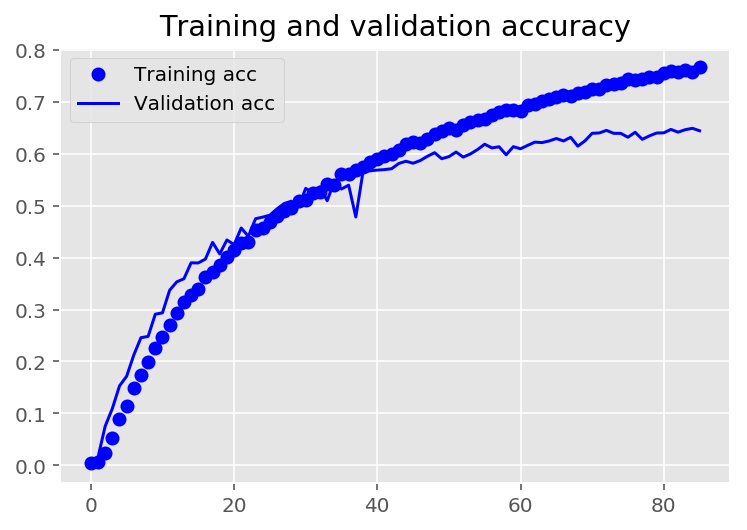

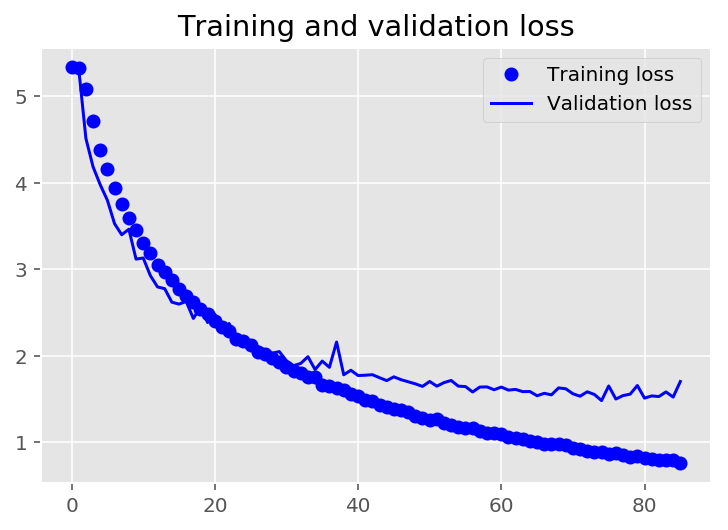

In [13]:
plot_accuracy_loss(history)

--- 

In [45]:
def train(model, 
          training_dir,
          validation_dir,
          target_size=TARGET_SIZE, 
          training_samples=TRAINING_SAMPLES, 
          validation_samples=VALIDATION_SAMPLES,
          epochs=1000, 
          batch_size=512, 
          load_previous_weights=True,
          model_weights_file=None):
    """
    
    """
    
    if model_weights_file is None:
        raise("No model weights file set")
    
    print("Training STARTED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    if model_weights_file is not None and os.path.isfile(model_weights_file) and load_previous_weights:
        print("Loading weights from file {}".format(model_weights_file))
        model.load_weights(model_weights_file)

    model.compile(
        loss='categorical_crossentropy', 
        optimizer='rmsprop', 
        metrics=['accuracy'])
    
    # create data generator 
    # check the official documentation for more details: https://keras.io/preprocessing/image/
    datagen = preprocessing.image.ImageDataGenerator(
        rescale=1./255., # rescaling factor applied by multiply the data by this value  
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2, # ranges (as a fraction of total width) to randomly translate pictures 
        height_shift_range=0.2, # ranges (as a fraction of total height) to randomly translate pictures 
        horizontal_flip=True, # randomly flipping half of the images horizontally
        fill_mode='nearest') # strategy used for filling in newly created pixels
    
    if model.layers[0].input_shape[0] == target_size[0] and model.layers[0].input_shape[1] == target_size[1]:
        target_size = None
    
    # create an iterator for the training data 
    train_generator = datagen.flow_from_directory(
        training_dir,
        shuffle = True,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale', 
        class_mode='categorical')
    
    # create an iterator for the validation data 
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        shuffle = True,
        target_size=target_size,
        batch_size=batch_size, 
        color_mode='grayscale', 
        class_mode='categorical')
    
    checkpoint = callbacks.ModelCheckpoint(model_weights_file, 
                                           monitor='val_loss', 
                                           verbose=0, 
                                           save_best_only=True, 
                                           save_weights_only=True, 
                                           mode='auto', 
                                           period=2)
    
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)
    
    data_augmentation_multiplier = 1.5 
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=int((training_samples/batch_size) * data_augmentation_multiplier),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int((validation_samples/batch_size) * data_augmentation_multiplier), 
        callbacks=[checkpoint, early_stopping]) 
    
    print("Training FINISHED - target size {}, batch size {}".format(
        target_size, 
        batch_size))
    
    return history, model     

In [46]:
def create_model(input_shape=(256,256,1), classes=CATEGORIES_COUNT, is_training=True):
    """
    Create a CNN model 
    """
    
    model = models.Sequential() 
    model.add(layers.Conv2D(16, kernel_size=(7,7), strides=(3,3),  
                            padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'))        
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Conv2D(64, (5,5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    if is_training:
        model.add(layers.Dropout(0.125))
    
    model.add(layers.Conv2D(128, (5,5), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2,2))    
    
    model.add(layers.Flatten())                
    model.add(layers.Dense(512, activation='relu'))
    if is_training:
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(classes, activation='softmax'))
    
    return model

In [47]:
model = create_model() 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 86, 86, 16)        800       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 43, 43, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 43, 43, 32)        12832     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 21, 21, 64)        51264     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 10, 10, 64)        0         
__________

In [49]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(256,256),
                       epochs=1000, 
                       batch_size=256,
                       model_weights_file="/output/cnn_sketch_weights_9.h5", 
                       load_previous_weights=True)

Training STARTED - target size (256, 256), batch size 256
Loading weights from file /output/cnn_sketch_weights_9.h5
Found 13292 images belonging to 205 classes.
Found 3452 images belonging to 205 classes.
Epoch 1/1000
74/74 [==============================] - 124s - loss: 1.2332 - acc: 0.6671 - val_loss: 1.5529 - val_acc: 0.6396
Epoch 2/1000
74/74 [==============================] - 111s - loss: 1.1416 - acc: 0.6877 - val_loss: 1.4734 - val_acc: 0.6334
Epoch 3/1000
74/74 [==============================] - 110s - loss: 1.1243 - acc: 0.6877 - val_loss: 1.4961 - val_acc: 0.6367
Epoch 4/1000
74/74 [==============================] - 111s - loss: 1.1411 - acc: 0.6838 - val_loss: 1.4856 - val_acc: 0.6408
Epoch 5/1000
74/74 [==============================] - 111s - loss: 1.1573 - acc: 0.6846 - val_loss: 1.4358 - val_acc: 0.6510
Epoch 6/1000
74/74 [==============================] - 110s - loss: 1.1206 - acc: 0.6904 - val_loss: 1.5300 - val_acc: 0.6395
Epoch 7/1000
74/74 [=========================

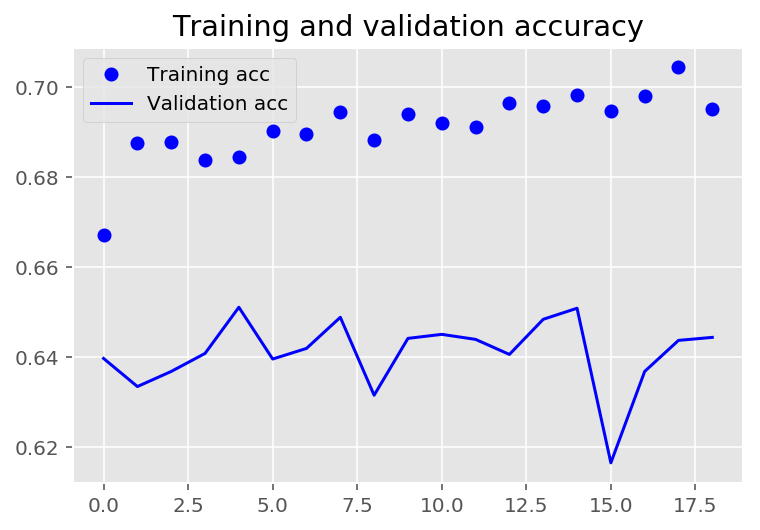

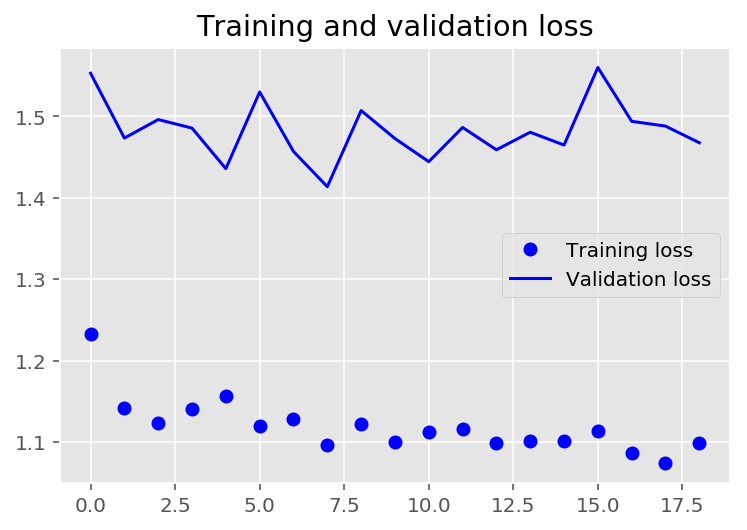

In [50]:
plot_accuracy_loss(history)

--- 

In [56]:
def create_model(input_shape=(256,256,1), classes=CATEGORIES_COUNT, is_training=True):
    """
    Create a CNN model 
    """
    
    input_tensor = Input(shape=input_shape)
    
    # layer 1 
    layer1_conv_1 = layers.Conv2D(64, kernel_size=(15, 15), strides=(3,3), activation='relu')(input_tensor)
    layer1_pool_1 = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(layer1_conv_1)
    
    # layer 2
    layer2_conv_1 = layers.Conv2D(128, kernel_size=(5,5), strides=(1,1), activation='relu')(layer1_pool_1)
    layer2_pool_1 = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(layer2_conv_1)
    
    # layer 3
    layer3_conv_1 = layers.Conv2D(256, kernel_size=(5,5), strides=(1,1), activation='relu')(layer2_pool_1)
    layer3_pool_1 = layers.MaxPooling2D(pool_size=(3,3), strides=(2,2))(layer3_conv_1)
    
    # tower A 
    sparse_conv_a1 = layers.Conv2D(48, kernel_size=(1,1))(layer3_pool_1)
    sparse_conv_a2 = layers.Conv2D(64, kernel_size=(3,3))(sparse_conv_a1)
    
    # tower B 
    sparse_pool_b1 = layers.AveragePooling2D(pool_size=(3,3), strides=(1,1))(layer3_pool_1)
    sparse_conv_b2 = layers.Conv2D(64, kernel_size=(1,1))(sparse_pool_b1)
    
    # tower C 
    sparse_conv_c1 = layers.Conv2D(64, kernel_size=(3,3))(layer3_pool_1)
    
    merge_layer = layers.concatenate([sparse_conv_a2, sparse_conv_b2, sparse_conv_c1], axis=-1)  
    
    layer5_pool_1 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(merge_layer)
    
    flat = layers.Flatten()(layer5_pool_1)
    
    fc1 = layers.Dense(256, activation='relu')(flat)
    if is_training:
        dr = layers.Dropout(0.5)(fc1)    
        fc2 = layers.Dense(CATEGORIES_COUNT, activation='sigmoid')(dr)
        model = models.Model(input_tensor,fc2)
    else:                
        fc2 = layers.Dense(CATEGORIES_COUNT, activation='sigmoid')(fc1)
        model = models.Model(input_tensor,fc2)
        
    return model         

In [57]:
model = create_model() 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_59 (Conv2D)               (None, 81, 81, 64)    14464       input_2[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D)  (None, 40, 40, 64)    0           conv2d_59[0][0]                  
____________________________________________________________________________________________________
conv2d_60 (Conv2D)               (None, 36, 36, 128)   204928      max_pooling2d_31[0][0]           
___________________________________________________________________________________________

In [ ]:
history, model = train(model, 
                       training_dir=os.path.join(DEST_SKETCH_DIR, 'training'), 
                       validation_dir=os.path.join(DEST_SKETCH_DIR, 'validation'), 
                       target_size=(256,256),
                       epochs=1000, 
                       batch_size=300,
                       model_weights_file="/output/cnn_sketch_weights_10.h5", 
                       load_previous_weights=True)

Training STARTED - target size (256, 256), batch size 300
Found 13292 images belonging to 205 classes.
Found 3452 images belonging to 205 classes.
Epoch 1/1000
63/63 [==============================] - 125s - loss: 5.3421 - acc: 0.0045 - val_loss: 5.3225 - val_acc: 0.0078
Epoch 2/1000
63/63 [==============================] - 109s - loss: 5.3239 - acc: 0.0056 - val_loss: 5.3223 - val_acc: 0.0080
Epoch 3/1000
63/63 [==============================] - 109s - loss: 5.3244 - acc: 0.0055 - val_loss: 5.3209 - val_acc: 0.0092
Epoch 4/1000
63/63 [==============================] - 109s - loss: 5.3234 - acc: 0.0048 - val_loss: 5.3209 - val_acc: 0.0085
Epoch 5/1000
63/63 [==============================] - 108s - loss: 5.3235 - acc: 0.0057 - val_loss: 5.3209 - val_acc: 0.0080
Epoch 6/1000
63/63 [==============================] - 108s - loss: 5.3232 - acc: 0.0048 - val_loss: 5.3205 - val_acc: 0.0090
Epoch 7/1000
63/63 [==============================] - 109s - loss: 5.3236 - acc: 0.0058 - val_loss: 5.3

In [ ]:
plot_accuracy_loss(history)